Topics Covered:
1. Creating and Visualizing Signed Networks
2. Balance Theory and Balance Index
3. Centrality Measures in Signed Networks
4. Community Detection
5. Link Prediction
6. Optimization based community detection

Author: C. Sonnet and H. Pirim


PART 1: CREATING AND VISUALIZING SIGNED NETWORKS

Network created with 6 nodes and 10 edges
Positive edges: 6
Negative edges: 4


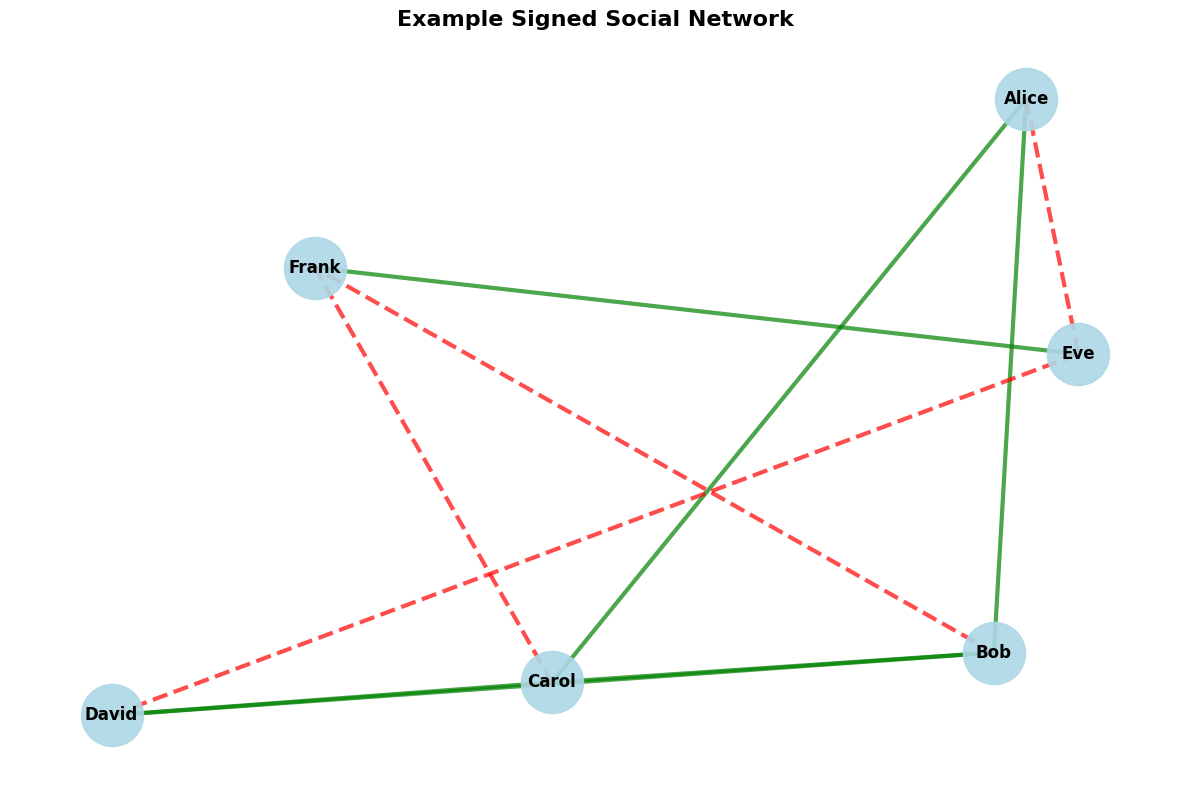


PART 2: BALANCE THEORY AND BALANCE INDEX

Balance Index: 1.000
Balanced triangles: 3
Unbalanced triangles: 0

--- BALANCED TRIANGLES ---
  ['Alice', 'Bob', 'Carol']: 3+ 0-
  ['Bob', 'Carol', 'David']: 3+ 0-
  ['Bob', 'Carol', 'Frank']: 1+ 2-

--- UNBALANCED TRIANGLES ---


Balanced Network - Balance Index: 1.000


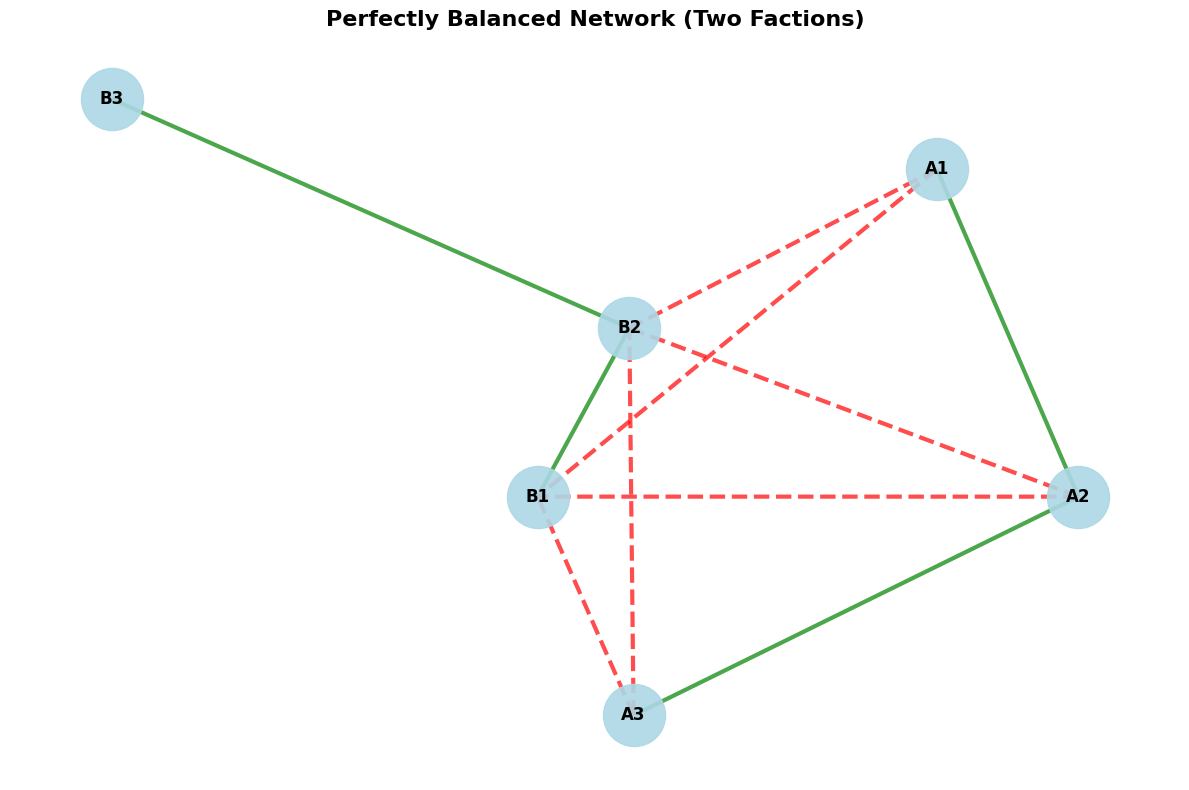


PART 3: CENTRALITY MEASURES IN SIGNED NETWORKS

IMPORTANT NOTE: Standard centrality measures (betweenness, closeness) 
were designed for unsigned networks and DON'T properly account for edge signs!

Key Issues:
1. SHORTEST PATHS: What is the "shortest" path through mixed +/- edges?
2. BETWEENNESS: Should nodes on negative edge paths count as bridges?
3. CLOSENESS: How to measure "distance" through enemy relationships?

Solutions in Literature:
- Walk-based methods: Consider ALL paths, not just shortest
- Sign-aware paths: Only use positive edges for distances
- Effect propagation: Model how influence spreads with signs


PART 3: CENTRALITY MEASURES IN SIGNED NETWORKS

--- SIGNED DEGREE CENTRALITY ---
Node       Pos Deg    Neg Deg    Net Deg   
----------------------------------------
Alice      2          1          1         
Bob        3          1          2         
Carol      3          1          2         
David      2          1          1         
Eve        1          2     

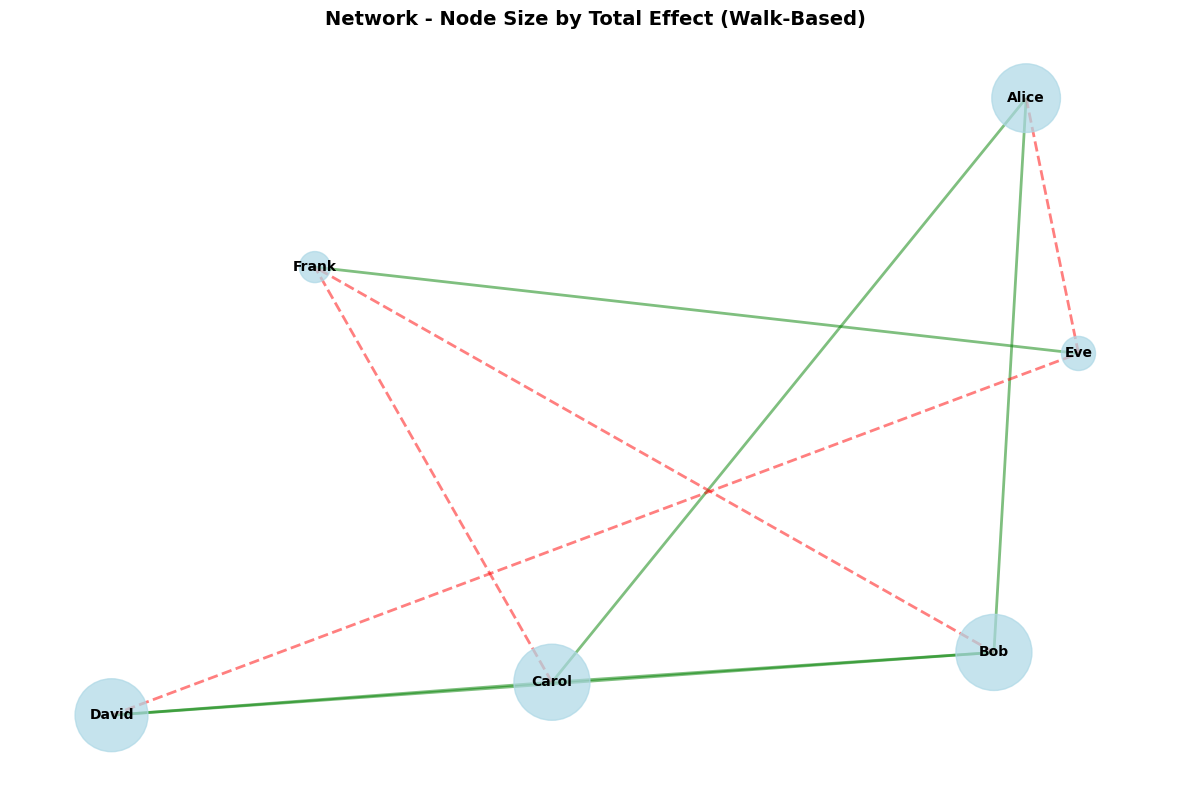


PART 4: COMMUNITY DETECTION IN SIGNED NETWORKS

--- DETECTED COMMUNITIES ---
Community 0: ['Alice', 'Bob', 'Carol', 'Frank']
Community 1: ['David', 'Eve']

--- COMMUNITY QUALITY ANALYSIS ---
Internal positive edges: 3 (good)
Internal negative edges: 3 (bad)
External positive edges: 3 (bad)
External negative edges: 1 (good)

Community Quality Score: 0.400


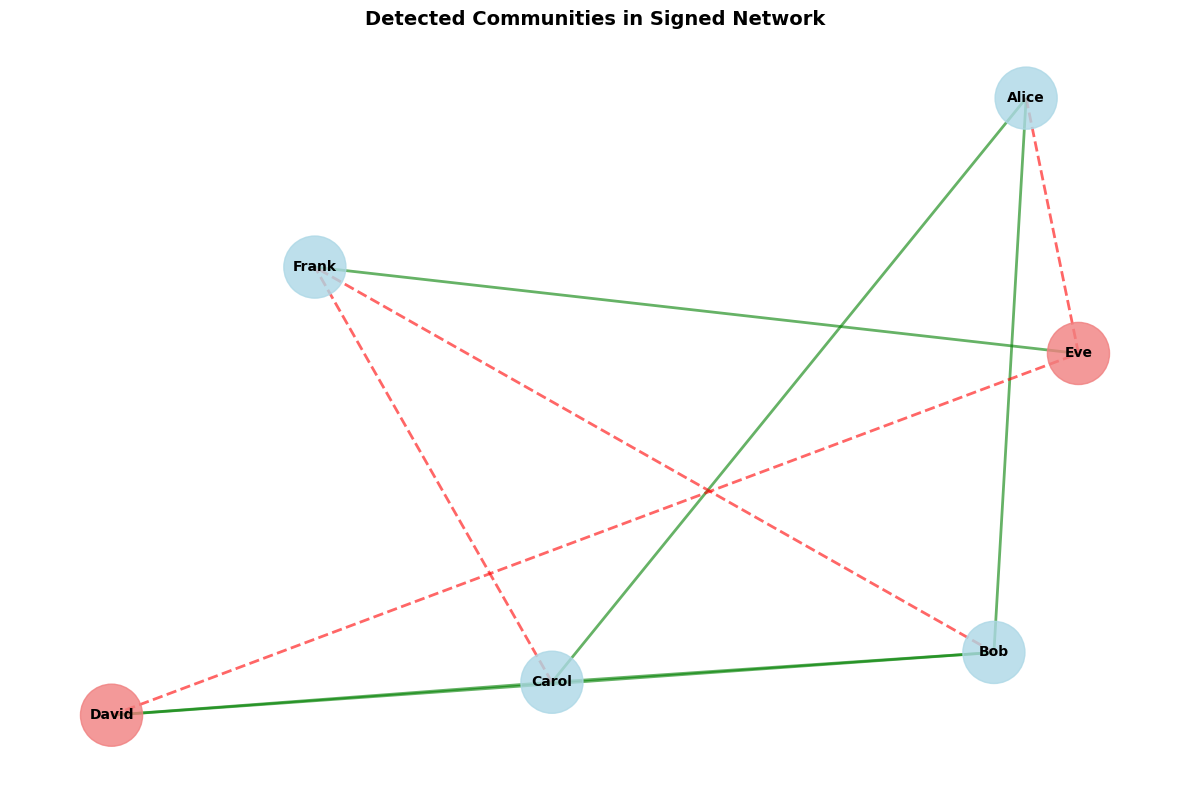


PART 5: LINK PREDICTION IN SIGNED NETWORKS

--- PREDICTION: Alice -> David ---
Predicted sign: +
Confidence: 100.00%

Basis (common neighbors):
  Via Eve: Alice- Eve- -> predict +
  Via Bob: Alice+ Bob+ -> predict +
  Via Carol: Alice+ Carol+ -> predict +


In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# PART 1: CREATING AND VISUALIZING SIGNED NETWORKS
# ==============================================================================

def create_signed_network():
    """
    Create a sample signed network with positive and negative edges
    """
    G = nx.Graph()
    
    # Add nodes
    nodes = ['Alice', 'Bob', 'Carol', 'David', 'Eve', 'Frank']
    G.add_nodes_from(nodes)
    
    # Add positive edges (friends)
    # Modified to include triangles for balance theory analysis
    positive_edges = [
        ('Alice', 'Bob'), ('Alice', 'Carol'), ('Bob', 'Carol'),  # Triangle 1: All positive
        ('Bob', 'David'), ('Carol', 'David'),  # Triangle 2 (with Bob-Carol)
        ('Eve', 'Frank')
    ]
    
    # Add negative edges (enemies)
    negative_edges = [
        ('Alice', 'Eve'), ('Bob', 'Frank'),
        ('Carol', 'Frank'), ('David', 'Eve')
    ]
    
    # Add edges with sign attribute
    for edge in positive_edges:
        G.add_edge(edge[0], edge[1], sign=1, relation='friend')
    
    for edge in negative_edges:
        G.add_edge(edge[0], edge[1], sign=-1, relation='enemy')
    
    return G

def visualize_signed_network(G, title="Signed Network"):
    """
    Visualize a signed network with different colors for positive/negative edges
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Separate positive and negative edges
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('sign', 1) == 1]
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('sign', 1) == -1]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=2000, alpha=0.9)
    
    # Draw positive edges (solid green)
    nx.draw_networkx_edges(G, pos, edgelist=positive_edges,
                          edge_color='green', width=3, alpha=0.7)
    
    # Draw negative edges (dashed red)
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges,
                          edge_color='red', width=3, alpha=0.7,
                          style='dashed')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("="*70)
print("PART 1: CREATING AND VISUALIZING SIGNED NETWORKS")
print("="*70)

# Create and visualize a signed network
G = create_signed_network()
print(f"\nNetwork created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Positive edges: {len([(u,v) for u,v,d in G.edges(data=True) if d['sign']==1])}")
print(f"Negative edges: {len([(u,v) for u,v,d in G.edges(data=True) if d['sign']==-1])}")

visualize_signed_network(G, "Example Signed Social Network")

# ==============================================================================
# PART 2: BALANCE THEORY AND BALANCE INDEX
# ==============================================================================

def get_triangle_sign(G, triangle):
    """
    Calculate the sign of a triangle (product of edge signs)
    Returns: 1 (balanced) or -1 (unbalanced)
    """
    nodes = list(triangle)
    
    # Get signs of the three edges
    sign1 = G[nodes[0]][nodes[1]]['sign']
    sign2 = G[nodes[1]][nodes[2]]['sign']
    sign3 = G[nodes[2]][nodes[0]]['sign']
    
    # Product of signs
    return sign1 * sign2 * sign3

def calculate_balance_index(G):
    """
    Calculate the balance index of a signed network
    Balance Index = (Number of balanced triangles) / (Total triangles)
    """
    triangles = [clique for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    
    if len(triangles) == 0:
        return None, [], []
    
    balanced_triangles = []
    unbalanced_triangles = []
    
    for triangle in triangles:
        sign = get_triangle_sign(G, triangle)
        if sign == 1:
            balanced_triangles.append(triangle)
        else:
            unbalanced_triangles.append(triangle)
    
    balance_index = len(balanced_triangles) / len(triangles)
    
    return balance_index, balanced_triangles, unbalanced_triangles

def analyze_triangle_types(G, balanced, unbalanced):
    """
    Categorize triangles by their edge sign patterns
    """
    def get_pattern(G, triangle):
        nodes = list(triangle)
        signs = [
            G[nodes[0]][nodes[1]]['sign'],
            G[nodes[1]][nodes[2]]['sign'],
            G[nodes[2]][nodes[0]]['sign']
        ]
        pos_count = sum(1 for s in signs if s == 1)
        return f"{pos_count}+ {3-pos_count}-"
    
    print("\n--- BALANCED TRIANGLES ---")
    for tri in balanced:
        pattern = get_pattern(G, tri)
        print(f"  {tri}: {pattern}")
    
    print("\n--- UNBALANCED TRIANGLES ---")
    for tri in unbalanced:
        pattern = get_pattern(G, tri)
        print(f"  {tri}: {pattern}")

print("\n" + "="*70)
print("PART 2: BALANCE THEORY AND BALANCE INDEX")
print("="*70)

balance_idx, balanced, unbalanced = calculate_balance_index(G)

print(f"\nBalance Index: {balance_idx:.3f}")
print(f"Balanced triangles: {len(balanced)}")
print(f"Unbalanced triangles: {len(unbalanced)}")

analyze_triangle_types(G, balanced, unbalanced)

# Create a perfectly balanced network for comparison
def create_balanced_network():
    """Create a perfectly balanced network with two factions"""
    G_balanced = nx.Graph()
    
    # Faction 1
    faction1 = ['A1', 'A2', 'A3']
    # Faction 2
    faction2 = ['B1', 'B2', 'B3']
    
    # Positive edges within factions
    for i in range(len(faction1)-1):
        G_balanced.add_edge(faction1[i], faction1[i+1], sign=1)
    for i in range(len(faction2)-1):
        G_balanced.add_edge(faction2[i], faction2[i+1], sign=1)
    
    # Negative edges between factions
    for a in faction1:
        for b in faction2[:2]:  # Not all to keep it sparse
            G_balanced.add_edge(a, b, sign=-1)
    
    return G_balanced

G_balanced = create_balanced_network()
balance_idx_perfect, _, _ = calculate_balance_index(G_balanced)
print(f"\n\nBalanced Network - Balance Index: {balance_idx_perfect:.3f}")
visualize_signed_network(G_balanced, "Perfectly Balanced Network (Two Factions)")

# ==============================================================================
# PART 3: CENTRALITY MEASURES IN SIGNED NETWORKS
# ==============================================================================

print("\n" + "="*70)
print("PART 3: CENTRALITY MEASURES IN SIGNED NETWORKS")
print("="*70)
print("""
IMPORTANT NOTE: Standard centrality measures (betweenness, closeness) 
were designed for unsigned networks and DON'T properly account for edge signs!

Key Issues:
1. SHORTEST PATHS: What is the "shortest" path through mixed +/- edges?
2. BETWEENNESS: Should nodes on negative edge paths count as bridges?
3. CLOSENESS: How to measure "distance" through enemy relationships?

Solutions in Literature:
- Walk-based methods: Consider ALL paths, not just shortest
- Sign-aware paths: Only use positive edges for distances
- Effect propagation: Model how influence spreads with signs
""")

def signed_degree_centrality(G):
    """
    Calculate signed degree centrality: d+ - d-
    """
    centrality = {}
    
    for node in G.nodes():
        pos_degree = sum(1 for _, _, data in G.edges(node, data=True) 
                        if data.get('sign', 1) == 1)
        neg_degree = sum(1 for _, _, data in G.edges(node, data=True) 
                        if data.get('sign', 1) == -1)
        
        centrality[node] = {
            'positive_degree': pos_degree,
            'negative_degree': neg_degree,
            'net_degree': pos_degree - neg_degree
        }
    
    return centrality

def signed_walk_effect(G, max_steps=3):
    """
    Calculate walk-based centrality for signed networks.
    Based on: Liu et al. (2020) "A simple approach for quantifying node 
    centrality in signed and directed social networks"
    
    This computes the total effect and net effect of each node by considering
    how effects propagate along walks (not just shortest paths).
    """
    nodes = list(G.nodes())
    n = len(nodes)
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Initialize direct effect matrix
    A = np.zeros((n, n))
    for u, v, data in G.edges(data=True):
        i, j = node_to_idx[u], node_to_idx[v]
        sign = data.get('sign', 1)
        degree_v = G.degree(v)
        if degree_v > 0:
            # Direct effect from u to v
            A[i, j] = sign / degree_v
            # For undirected, also v to u
            A[j, i] = sign / degree_v
    
    # Calculate cumulative effects up to max_steps
    total_effect = np.eye(n)  # Start with identity (self-effect)
    current = A.copy()
    
    for step in range(1, max_steps + 1):
        total_effect += current
        current = current @ A  # Next step effects
    
    # Calculate metrics for each node
    results = {}
    for i, node in enumerate(nodes):
        row_sum = np.sum(total_effect[i, :])  # Total effect exerted
        col_sum = np.sum(total_effect[:, i])  # Total effect received
        
        # Separate positive and negative effects
        positive_effect = np.sum(total_effect[i, :][total_effect[i, :] > 0])
        negative_effect = np.sum(np.abs(total_effect[i, :][total_effect[i, :] < 0]))
        net_effect = positive_effect - negative_effect
        
        results[node] = {
            'total_effect': row_sum,
            'net_effect': net_effect,
            'positive_effect': positive_effect,
            'negative_effect': negative_effect
        }
    
    return results

def signed_betweenness_approximation(G):
    """
    Approximate betweenness for signed networks.
    Uses unsigned graph structure (ignores signs) to count paths,
    then weights by edge signs.
    
    Note: True signed betweenness is complex because negative edges
    affect which paths are "useful" for communication.
    """
    # Create unsigned version for path counting
    G_unsigned = nx.Graph()
    G_unsigned.add_nodes_from(G.nodes())
    G_unsigned.add_edges_from(G.edges())
    
    # Calculate standard betweenness on unsigned graph
    betweenness = nx.betweenness_centrality(G_unsigned)
    
    # Weight by local sign environment
    weighted_betweenness = {}
    for node in G.nodes():
        # Count positive vs negative edges
        pos_edges = sum(1 for _, _, d in G.edges(node, data=True) if d.get('sign', 1) == 1)
        neg_edges = sum(1 for _, _, d in G.edges(node, data=True) if d.get('sign', 1) == -1)
        total_edges = pos_edges + neg_edges
        
        # Adjust betweenness by sign ratio
        if total_edges > 0:
            sign_ratio = (pos_edges - neg_edges) / total_edges
            weighted_betweenness[node] = betweenness[node] * (1 + sign_ratio) / 2
        else:
            weighted_betweenness[node] = 0.0
    
    return weighted_betweenness

def signed_closeness_harmonic(G):
    """
    Harmonic closeness for signed networks.
    
    Issue: In signed networks, "distance" through negative edges is unclear.
    Approaches:
    1. Ignore negative edges (only use positive paths)
    2. Treat negative edges as barriers (infinite distance)
    3. Use harmonic mean to handle disconnected components
    
    This implementation uses approach 1: only positive edges for paths.
    """
    # Create subgraph with only positive edges
    G_positive = nx.Graph()
    G_positive.add_nodes_from(G.nodes())
    for u, v, data in G.edges(data=True):
        if data.get('sign', 1) == 1:
            G_positive.add_edge(u, v)
    
    closeness = {}
    for node in G.nodes():
        # Calculate harmonic closeness (sum of inverse distances)
        harmonic_sum = 0.0
        for target in G.nodes():
            if node != target:
                try:
                    distance = nx.shortest_path_length(G_positive, node, target)
                    harmonic_sum += 1.0 / distance
                except nx.NetworkXNoPath:
                    # No path through positive edges - contributes 0
                    pass
        
        # Normalize by number of nodes - 1
        closeness[node] = harmonic_sum / (len(G.nodes()) - 1) if len(G.nodes()) > 1 else 0
    
    return closeness

def calculate_all_signed_centralities(G):
    """
    Calculate multiple centrality measures for signed networks.
    
    Note: Standard centrality measures don't account for edge signs!
    We provide several signed-aware alternatives.
    """
    # Signed degree centrality
    signed_degree = signed_degree_centrality(G)
    
    # Walk-based centrality (total and net effect)
    walk_centrality = signed_walk_effect(G, max_steps=3)
    
    # Approximate signed betweenness
    signed_betweenness = signed_betweenness_approximation(G)
    
    # Harmonic closeness (positive edges only)
    signed_closeness = signed_closeness_harmonic(G)
    
    # For comparison: unsigned versions (WARNING: these ignore signs!)
    degree_cent = nx.degree_centrality(G)
    
    return {
        'signed_degree': signed_degree,
        'walk_total_effect': {n: walk_centrality[n]['total_effect'] for n in G.nodes()},
        'walk_net_effect': {n: walk_centrality[n]['net_effect'] for n in G.nodes()},
        'signed_betweenness': signed_betweenness,
        'signed_closeness': signed_closeness,
        'degree_unsigned': degree_cent  # For comparison only
    }

print("\n" + "="*70)
print("PART 3: CENTRALITY MEASURES IN SIGNED NETWORKS")
print("="*70)

centralities = calculate_all_signed_centralities(G)

print("\n--- SIGNED DEGREE CENTRALITY ---")
print(f"{'Node':<10} {'Pos Deg':<10} {'Neg Deg':<10} {'Net Deg':<10}")
print("-" * 40)
for node, values in sorted(centralities['signed_degree'].items()):
    print(f"{node:<10} {values['positive_degree']:<10} "
          f"{values['negative_degree']:<10} {values['net_degree']:<10}")

print("\n--- WALK-BASED CENTRALITY (Signed Networks) ---")
print("Based on effect propagation along walks (not shortest paths)")
print(f"{'Node':<10} {'Total Effect':<15} {'Net Effect':<15}")
print("-" * 40)
for node in sorted(G.nodes()):
    print(f"{node:<10} {centralities['walk_total_effect'][node]:<15.3f} "
          f"{centralities['walk_net_effect'][node]:<15.3f}")

print("\n--- SIGNED BETWEENNESS & CLOSENESS ---")
print("Note: These are approximations for signed networks")
print(f"{'Node':<10} {'S-Betweenness':<15} {'S-Closeness':<15}")
print("-" * 40)
for node in sorted(G.nodes()):
    print(f"{node:<10} {centralities['signed_betweenness'][node]:<15.3f} "
          f"{centralities['signed_closeness'][node]:<15.3f}")

print("\n" + "="*70)
print("INTERPRETATION GUIDE:")
print("="*70)
print("""
1. SIGNED DEGREE: Net influence = positive connections - negative connections
   - Positive: Well-liked, influential
   - Negative: Controversial, many enemies
   
2. WALK-BASED CENTRALITY:
   - Total Effect: Overall influence (regardless of sign)
   - Net Effect: Positive influence - Negative influence
   - Based on all walks up to length 3
   
3. SIGNED BETWEENNESS: Bridge role, weighted by edge signs
   - Nodes with positive edges are better bridges
   
4. SIGNED CLOSENESS: Reachability through positive edges only
   - High values mean accessible through friendly connections
""")

def visualize_centrality(G, centrality_dict, title="Network Centrality"):
    """
    Visualize a network with node sizes proportional to centrality values
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Normalize centrality values for node sizes
    values = list(centrality_dict.values())
    min_val = min(values)
    max_val = max(values)
    
    # Scale node sizes between 500 and 3000
    if max_val > min_val:
        node_sizes = [500 + 2500 * (centrality_dict[node] - min_val) / (max_val - min_val) 
                      for node in G.nodes()]
    else:
        node_sizes = [1500 for _ in G.nodes()]
    
    # Separate positive and negative edges
    pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('sign', 1) == 1]
    neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('sign', 1) == -1]
    
    # Draw nodes with size based on centrality
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=node_sizes, alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges,
                          edge_color='green', width=2, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges,
                          edge_color='red', width=2, alpha=0.5, style='dashed')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize walk-based total effect
visualize_centrality(G, centralities['walk_total_effect'], 
                    "Network - Node Size by Total Effect (Walk-Based)")

# ==============================================================================
# PART 4: COMMUNITY DETECTION IN SIGNED NETWORKS
# ==============================================================================

def simple_signed_community_detection(G, num_communities=2):
    """
    Simple spectral clustering approach for signed networks
    """
    # Create adjacency matrix
    nodes = list(G.nodes())
    n = len(nodes)
    A = nx.adjacency_matrix(G, weight='sign').toarray()
    
    # Compute Laplacian
    D = np.diag(np.sum(np.abs(A), axis=1))
    L = D - A
    
    # Find eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # Use second smallest eigenvector for 2 communities
    fiedler_vector = eigenvectors[:, 1]
    
    # Partition based on sign of Fiedler vector
    communities = {}
    for i, node in enumerate(nodes):
        communities[node] = 0 if fiedler_vector[i] < 0 else 1
    
    return communities

def analyze_community_quality(G, communities):
    """
    Analyze the quality of detected communities
    """
    # Count internal positive and negative edges
    internal_pos = 0
    internal_neg = 0
    external_pos = 0
    external_neg = 0
    
    for u, v, data in G.edges(data=True):
        sign = data['sign']
        same_community = (communities[u] == communities[v])
        
        if same_community:
            if sign == 1:
                internal_pos += 1
            else:
                internal_neg += 1
        else:
            if sign == 1:
                external_pos += 1
            else:
                external_neg += 1
    
    print(f"\n--- COMMUNITY QUALITY ANALYSIS ---")
    print(f"Internal positive edges: {internal_pos} (good)")
    print(f"Internal negative edges: {internal_neg} (bad)")
    print(f"External positive edges: {external_pos} (bad)")
    print(f"External negative edges: {external_neg} (good)")
    
    # Quality score
    good_edges = internal_pos + external_neg
    bad_edges = internal_neg + external_pos
    quality = good_edges / (good_edges + bad_edges) if (good_edges + bad_edges) > 0 else 0
    
    print(f"\nCommunity Quality Score: {quality:.3f}")
    return quality

print("\n" + "="*70)
print("PART 4: COMMUNITY DETECTION IN SIGNED NETWORKS")
print("="*70)

communities = simple_signed_community_detection(G)

print("\n--- DETECTED COMMUNITIES ---")
for comm_id in set(communities.values()):
    members = [node for node, c in communities.items() if c == comm_id]
    print(f"Community {comm_id}: {members}")

analyze_community_quality(G, communities)

# Visualize communities
def visualize_communities(G, communities):
    """Visualize network with communities colored"""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color nodes by community
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    node_colors = [colors[communities[node]] for node in G.nodes()]
    
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']==1]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']==-1]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=2000, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges,
                          edge_color='green', width=2, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges,
                          edge_color='red', width=2, style='dashed', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("Detected Communities in Signed Network", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_communities(G, communities)

# ==============================================================================
# PART 5: LINK PREDICTION IN SIGNED NETWORKS
# ==============================================================================

def predict_edge_sign(G, node1, node2):
    """
    Predict the sign of an edge between two nodes based on balance theory
    """
    # Find common neighbors
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    common_neighbors = neighbors1.intersection(neighbors2)
    
    if len(common_neighbors) == 0:
        return None, "No common neighbors for prediction"
    
    # Count balanced and unbalanced predictions
    vote_positive = 0
    vote_negative = 0
    
    details = []
    
    for neighbor in common_neighbors:
        sign1 = G[node1][neighbor]['sign']
        sign2 = G[node2][neighbor]['sign']
        
        # For balance, if both signs are same, predict positive
        # If signs differ, predict negative
        if sign1 * sign2 == 1:
            vote_positive += 1
            prediction = "+"
        else:
            vote_negative += 1
            prediction = "-"
        
        details.append({
            'neighbor': neighbor,
            'node1_sign': '+' if sign1 == 1 else '-',
            'node2_sign': '+' if sign2 == 1 else '-',
            'prediction': prediction
        })
    
    # Final prediction
    predicted_sign = 1 if vote_positive > vote_negative else -1
    confidence = max(vote_positive, vote_negative) / (vote_positive + vote_negative)
    
    return predicted_sign, confidence, details

print("\n" + "="*70)
print("PART 5: LINK PREDICTION IN SIGNED NETWORKS")
print("="*70)

# Test link prediction
test_pairs = [('Alice', 'David'), ('Bob', 'Carol'), ('Eve', 'David')]

for node1, node2 in test_pairs:
    if not G.has_edge(node1, node2):
        sign, conf, details = predict_edge_sign(G, node1, node2)
        
        if sign is not None:
            print(f"\n--- PREDICTION: {node1} -> {node2} ---")
            print(f"Predicted sign: {'+' if sign == 1 else '-'}")
            print(f"Confidence: {conf:.2%}")
            print("\nBasis (common neighbors):")
            for d in details:
                print(f"  Via {d['neighbor']}: {node1}{d['node1_sign']} "
                      f"{d['neighbor']}{d['node2_sign']} -> predict {d['prediction']}")



# Optimization for Finding Communities 

Signed Network Community Detection via Integer Linear Programming
==================================================================

Mathematical Formulation:
    minimize  Σ_{(i,j)∈E} f_{ij}
    
    s.t.  Σ_{c∈C} x_{ic} = 1                    ∀i ∈ V
          f_{ij} ≥ x_{ic} - x_{jc}              ∀(i,j) ∈ E^+, ∀c ∈ C
          f_{ij} ≥ x_{ic} + x_{jc} - 1          ∀(i,j) ∈ E^-, ∀c ∈ C
          x_{ic} ∈ {0,1}                        ∀i ∈ V, ∀c ∈ C
          f_{ij} ∈ {0,1}                        ∀(i,j) ∈ E

Where:
- x_{ic} = 1 if node i is assigned to community c
- f_{ij} = 1 if edge (i,j) violates the partition
- E^+ = positive edges (should be within communities)
- E^- = negative edges (should be between communities)

SIGNED NETWORK ILP COMMUNITY DETECTION

### EXAMPLE 1: Simple Balanced Network ###

Network: 6 nodes, 6 positive edges, 3 negative edges
Detecting 2 communities...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/d855468e970444d7a2a481851f7e3270-pulp.mps -sec 60 -timeMode elapsed -branch -printingOptions all -solution /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/d855468e970444d7a2a481851f7e3270-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 29 COLUMNS
At line 147 RHS
At line 172 BOUNDS
At line 194 ENDATA
Problem MODEL has 24 rows, 21 columns and 66 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 18 

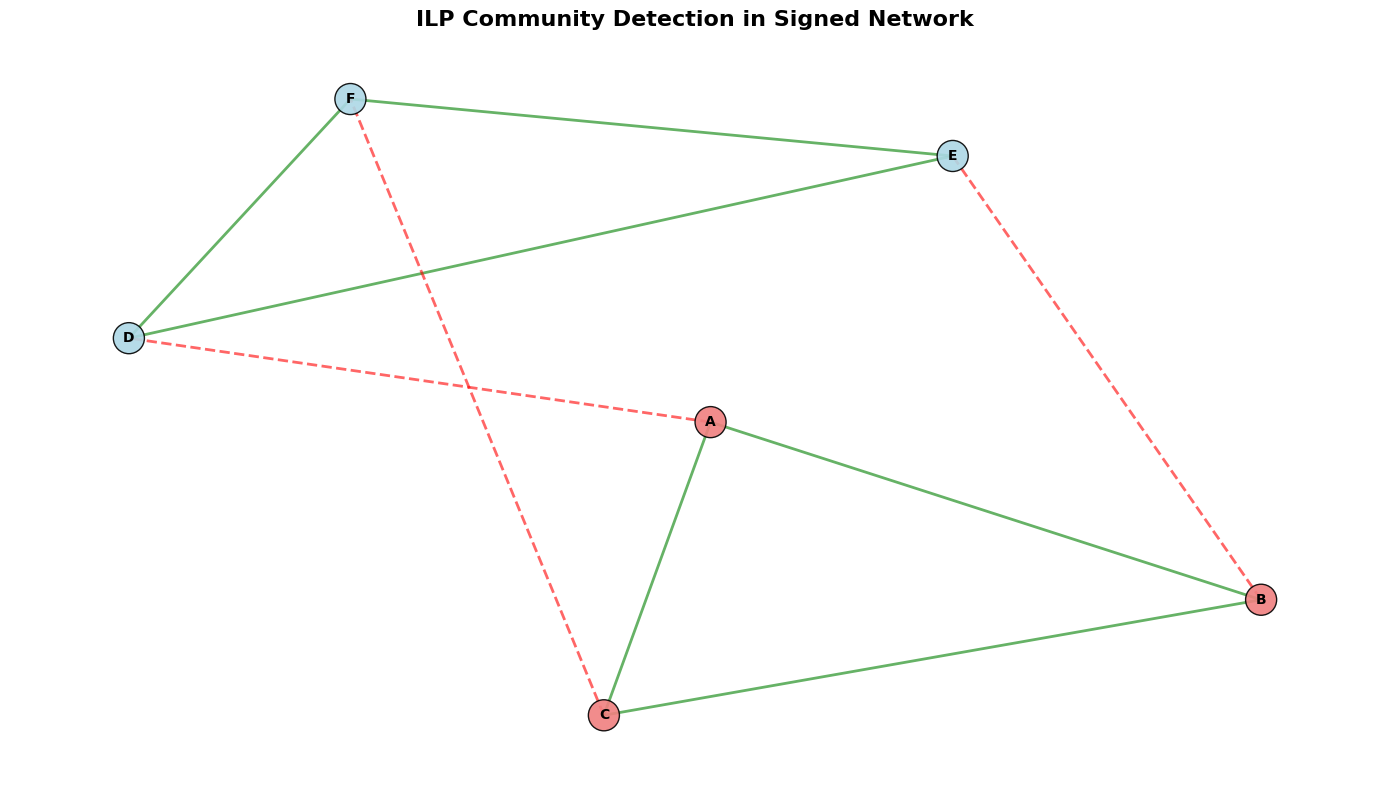



### EXAMPLE 2: Larger Network with Imbalance ###

Network: 15 nodes, 30 positive edges, 7 negative edges
Detecting 3 communities...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/03ed9b61fc6c4932b4749e2ad08da663-pulp.mps -sec 120 -timeMode elapsed -branch -printingOptions all -solution /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/03ed9b61fc6c4932b4749e2ad08da663-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 131 COLUMNS
At line 711 RHS
At line 838 BOUNDS
At line 921 ENDATA
Problem MODEL has 126 rows, 82 columns and 378 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 120
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 126 rows, 82 columns (82 int

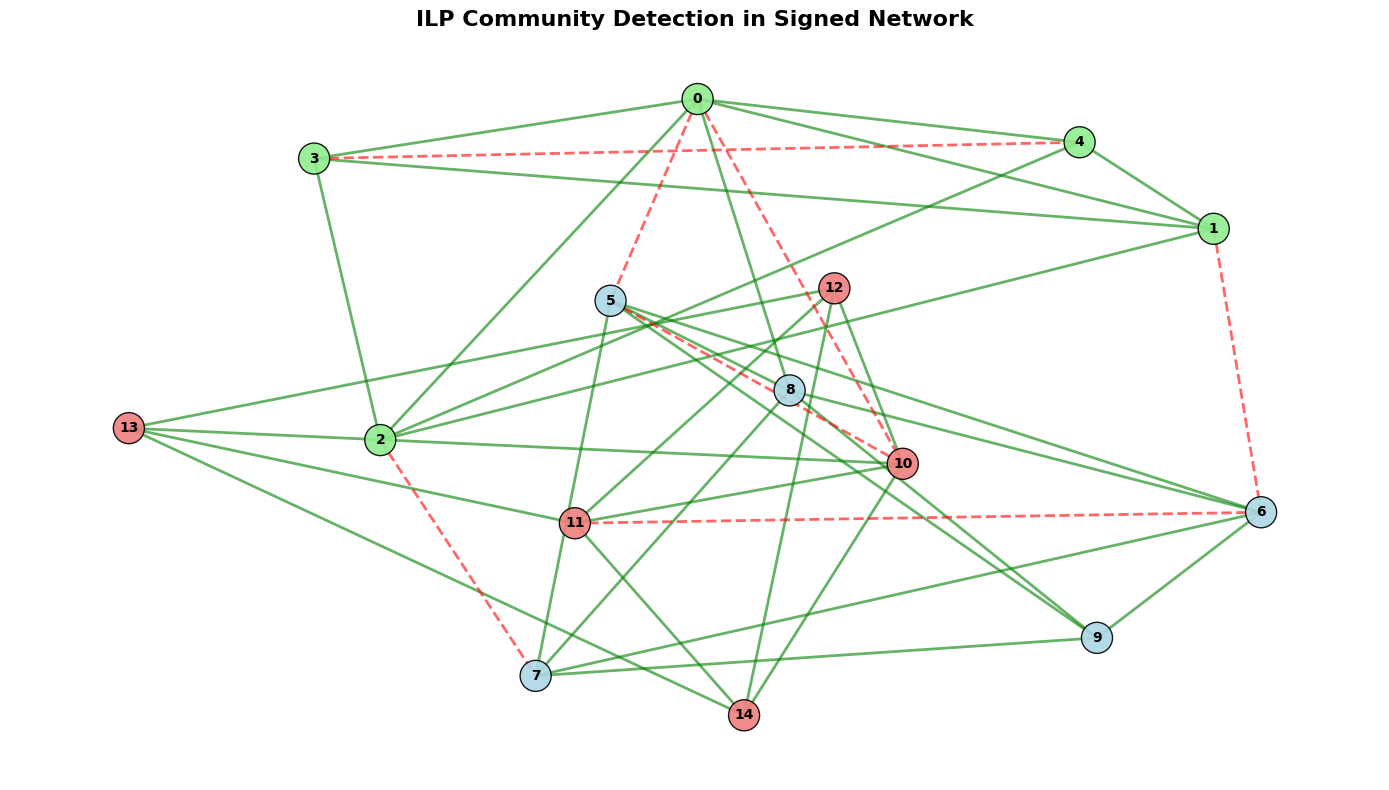


Done!


In [7]:
!pip install pulp
import networkx as nx
import numpy as np
from pulp import *

def signed_community_detection_ilp(G, num_communities, time_limit=60):
    """
    Detect communities in signed network using ILP formulation.
    
    Parameters
    ----------
    G : networkx.Graph
        Signed network with 'sign' edge attribute (+1 or -1)
    num_communities : int
        Number of communities to detect
    time_limit : int
        Maximum solving time in seconds
        
    Returns
    -------
    communities : dict
        Node to community assignment
    objective_value : float
        Number of violated edges
    status : str
        Solver status
    """
    
    # Extract nodes and edges
    nodes = list(G.nodes())
    n = len(nodes)
    communities = range(num_communities)
    
    # Separate positive and negative edges
    E_plus = []   # Positive edges (want within communities)
    E_minus = []  # Negative edges (want between communities)
    
    for u, v, data in G.edges(data=True):
        sign = data.get('sign', 1)
        if sign > 0:
            E_plus.append((u, v))
        else:
            E_minus.append((u, v))
    
    print(f"Network: {n} nodes, {len(E_plus)} positive edges, "
          f"{len(E_minus)} negative edges")
    print(f"Detecting {num_communities} communities...")
    
    # Create ILP problem
    prob = LpProblem("SignedCommunityDetection", LpMinimize)
    
    # Decision variables
    # x[i,c] = 1 if node i is in community c
    x = LpVariable.dicts("x", 
                         ((i, c) for i in nodes for c in communities),
                         cat='Binary')
    
    # f[i,j] = 1 if edge (i,j) violates the partition
    f = LpVariable.dicts("f",
                         ((i, j) for i, j in list(E_plus) + list(E_minus)),
                         cat='Binary')
    
    # Objective: Minimize total violations
    prob += lpSum([f[(i, j)] for i, j in list(E_plus) + list(E_minus)]), \
            "TotalViolations"
    
    # Constraint 1: Each node belongs to exactly one community
    for i in nodes:
        prob += lpSum([x[(i, c)] for c in communities]) == 1, \
                f"OneComm_{i}"
    
    # Constraint 2: Positive edges (want within communities)
    # f_ij >= |x_ic - x_jc| for all c
    # Since we want SAME community: f_ij >= x_ic - x_jc (if i in c, j not in c)
    for i, j in E_plus:
        for c in communities:
            prob += f[(i, j)] >= x[(i, c)] - x[(j, c)], \
                    f"PosEdge_{i}_{j}_c{c}"
    
    # Constraint 3: Negative edges (want between communities)
    # f_ij >= x_ic + x_jc - 1 for all c
    # This is 1 when both i and j are in community c
    for i, j in E_minus:
        for c in communities:
            prob += f[(i, j)] >= x[(i, c)] + x[(j, c)] - 1, \
                    f"NegEdge_{i}_{j}_c{c}"
    
    # Solve
    solver = PULP_CBC_CMD(msg=1, timeLimit=time_limit)
    prob.solve(solver)
    
    # Extract solution
    status = LpStatus[prob.status]
    objective_value = value(prob.objective)
    
    # Get community assignments
    node_communities = {}
    for i in nodes:
        for c in communities:
            if value(x[(i, c)]) > 0.5:  # Binary variable is 1
                node_communities[i] = c
                break
    
    print(f"\nSolver Status: {status}")
    print(f"Objective Value (violations): {objective_value}")
    
    return node_communities, objective_value, status


def analyze_solution(G, communities):
    """
    Analyze the quality of the community detection result.
    """
    # Count edge violations
    pos_within = 0  # Positive edges within communities (good)
    pos_between = 0  # Positive edges between communities (bad - violation)
    neg_within = 0   # Negative edges within communities (bad - violation)
    neg_between = 0  # Negative edges between communities (good)
    
    for u, v, data in G.edges(data=True):
        sign = data.get('sign', 1)
        same_comm = (communities[u] == communities[v])
        
        if sign > 0:
            if same_comm:
                pos_within += 1
            else:
                pos_between += 1
        else:
            if same_comm:
                neg_within += 1
            else:
                neg_between += 1
    
    total_violations = pos_between + neg_within
    total_edges = pos_within + pos_between + neg_within + neg_between
    
    print("\n" + "="*60)
    print("SOLUTION ANALYSIS")
    print("="*60)
    print(f"\nPositive edges:")
    print(f"  Within communities: {pos_within} ✓")
    print(f"  Between communities: {pos_between} ✗ (violations)")
    print(f"\nNegative edges:")
    print(f"  Within communities: {neg_within} ✗ (violations)")
    print(f"  Between communities: {neg_between} ✓")
    print(f"\nTotal violations: {total_violations} / {total_edges} edges")
    print(f"Quality score: {(1 - total_violations/total_edges)*100:.1f}%")
    
    # Community sizes
    print(f"\nCommunity sizes:")
    comm_sizes = {}
    for node, comm in communities.items():
        comm_sizes[comm] = comm_sizes.get(comm, 0) + 1
    for comm, size in sorted(comm_sizes.items()):
        members = [n for n, c in communities.items() if c == comm]
        print(f"  Community {comm}: {size} nodes - {members[:10]}"
              f"{'...' if len(members) > 10 else ''}")


def visualize_communities(G, communities):
    """
    Visualize the signed network with communities.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(14, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color nodes by community
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 
              'plum', 'peachpuff']
    node_colors = [colors[communities[node] % len(colors)] for node in G.nodes()]
    
    # Separate edges
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('sign',1) > 0]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('sign',1) < 0]
    
    # Draw
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=500, alpha=0.9, edgecolors='black')
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges,
                          edge_color='green', width=2, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges,
                          edge_color='red', width=2, style='dashed', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("ILP Community Detection in Signed Network", 
              fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("SIGNED NETWORK ILP COMMUNITY DETECTION")
    print("="*60)
    
    # Example 1: Simple balanced network (2 communities)
    print("\n### EXAMPLE 1: Simple Balanced Network ###\n")
    
    G = nx.Graph()
    
    # Community 1: A, B, C (all friends)
    G.add_edges_from([
        ('A', 'B', {'sign': 1}),
        ('B', 'C', {'sign': 1}),
        ('C', 'A', {'sign': 1})
    ])
    
    # Community 2: D, E, F (all friends)
    G.add_edges_from([
        ('D', 'E', {'sign': 1}),
        ('E', 'F', {'sign': 1}),
        ('F', 'D', {'sign': 1})
    ])
    
    # Between communities (all enemies)
    G.add_edges_from([
        ('A', 'D', {'sign': -1}),
        ('B', 'E', {'sign': -1}),
        ('C', 'F', {'sign': -1})
    ])
    
    communities, obj_val, status = signed_community_detection_ilp(G, num_communities=2)
    
    if status == "Optimal":
        analyze_solution(G, communities)
        visualize_communities(G, communities)
    
    
    # Example 2: Larger network with imbalance
    print("\n\n### EXAMPLE 2: Larger Network with Imbalance ###\n")
    
    G2 = nx.Graph()
    
    # Create 3 communities with some violations
    # Community 0
    for i in range(5):
        for j in range(i+1, 5):
            G2.add_edge(i, j, sign=1)
    
    # Community 1
    for i in range(5, 10):
        for j in range(i+1, 10):
            G2.add_edge(i, j, sign=1)
    
    # Community 2
    for i in range(10, 15):
        for j in range(i+1, 15):
            G2.add_edge(i, j, sign=1)
    
    # Add some negative edges between communities
    G2.add_edge(0, 5, sign=-1)
    G2.add_edge(1, 6, sign=-1)
    G2.add_edge(2, 7, sign=-1)
    G2.add_edge(5, 10, sign=-1)
    G2.add_edge(6, 11, sign=-1)
    G2.add_edge(0, 10, sign=-1)
    
    # Add some violations
    G2.add_edge(0, 8, sign=1)   # Positive between communities (violation)
    G2.add_edge(3, 4, sign=-1)  # Negative within community (violation)
    
    communities2, obj_val2, status2 = signed_community_detection_ilp(
        G2, num_communities=3, time_limit=120
    )
    
    if status2 == "Optimal":
        analyze_solution(G2, communities2)
        visualize_communities(G2, communities2)
    
    print("\n" + "="*60)
    print("Done!")
    print("="*60)